In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import glob
import requests
from statsmodels.stats.multitest import multipletests


def load_permutation_file(f):
    tissue, pcs = os.path.basename(f).split('.')[:2]
    tmp = pd.read_csv(f, sep='\t')
    tmp['tissue'] = tissue
    tmp['pcs'] = int(pcs)
    return tmp


def load_susie_cs(cs_file, converged_file):
    tissue, pcs = os.path.basename(cs_file).split('.')[:2]
    cs = pd.read_csv(cs_file, sep='\t')
    cs['tissue'] = tissue
    cs['pcs'] = int(pcs)

    converged = pd.read_csv(converged_file, sep='\t')
    assert(all(cs.phenotype_id.isin(converged.phenotype_id)))
    cs = cs.merge(converged)
    cs = cs[cs.converged].drop(columns=['converged'])
    
    return cs

# tick formatter converting to thousands
@FuncFormatter
def thousands(x, pos):
    if x == 0:
        return '0'
    if x % 1e3 == 0:
        return '%1.0fK' % (x*1e-3)
    else:
        return '%1.1fK' % (x*1e-3)


def get_eqtl_catalogue_permutations(study_id, dataset_id):
    df =  pd.read_csv(f'http://ftp.ebi.ac.uk/pub/databases/spot/eQTL/sumstats/{study_id}/{dataset_id}/{dataset_id}.permuted.tsv.gz', sep='\t')
    df['qval'] = multipletests(df.p_beta, method='fdr_bh')[1]
    return df


def get_eqtl_catalogue_susie(study_id, dataset_id):
    return pd.read_csv(f'ftp://ftp.ebi.ac.uk/pub/databases/spot/eQTL/susie/{study_id}/{dataset_id}/{dataset_id}.credible_sets.tsv.gz', sep='\t')

SATURATION_PERMUTATION_FILES = glob.glob('/net/topmed11/working/porchard/rnaseq-2024-10-16-sample-update/manuscript-intermediate-processing/data/scan-results/saturation/cis-eqtl/permutations/maf001/*')
SATURATION_SUSIE_FILES = glob.glob('/net/topmed11/working/porchard/rnaseq-2024-10-16-sample-update/manuscript-intermediate-processing/data/scan-results/saturation/cis-eqtl/susie/maf001/*.cs.txt')

FULL_PERMUTATION_FILE = '/net/topmed11/working/porchard/rnaseq-2024-10-16-sample-update/manuscript-intermediate-processing/data/scan-results/joint/cis-eqtl/permutations/maf001/Whole_blood.100.cis_qtl.txt.gz'
FULL_SUSIE_FILE = '/net/topmed11/working/porchard/rnaseq-2024-10-16-sample-update/manuscript-intermediate-processing/data/scan-results/joint/cis-eqtl/susie/maf001/Whole_blood.100.cs.txt'

GTEX_PERMUTATION_FILE = '/net/topmed11/working/porchard/gtex-preprocessing/data/gtex/GTEx_Analysis_v8_eQTL/Whole_Blood.v8.egenes.txt.gz'
GTEX_SUSIE_FILE = '/net/topmed11/working/porchard/gtex-preprocessing/data/gtex/GTEx_v8_finemapping_SuSiE/GTEx_v8.Whole_Blood.eQTL.SuSiE_summary.parquet'

PREFIX = 'Fig2B.'

FDR_COLUMN = 'qval'
FDR = 0.01
USE_PCS = 100
TOPMED_WHOLE_BLOOD_SAMPLE_SIZE = 6454
GTEX_WHOLE_BLOOD_SAMPLE_SIZE = 670

In [2]:
# TOPMed saturation analysis
permutations = pd.concat([load_permutation_file(f) for f in SATURATION_PERMUTATION_FILES])
permutations = permutations[permutations.pcs.isin(list(range(0, 110, 10)))]

cs = pd.concat([load_susie_cs(f, f.replace('.cs.txt', '.converged.txt')) for f in SATURATION_SUSIE_FILES])
cs = cs[cs.pcs.isin(list(range(0, 110, 10)))]

egenes = {(tissue, pcs): set(df[df[FDR_COLUMN] <= FDR].phenotype_id) for (tissue, pcs), df in permutations.groupby(['tissue', 'pcs'])}

cs['is_egene'] = [phenotype_id in egenes[(tissue, pcs)] for phenotype_id, tissue, pcs in zip(cs.phenotype_id, cs.tissue, cs.pcs)]
cs = cs[cs.is_egene].drop(columns=['is_egene'])

number_pcs_vs_egenes = permutations.groupby(['tissue', 'pcs'])[FDR_COLUMN].apply(lambda x: sum(x<=FDR)).rename('egenes').reset_index()
number_pcs_vs_egenes['sample_size'] = number_pcs_vs_egenes.tissue.str.replace('Whole_blood_', '').astype(int)

number_pcs_vs_cs = cs[['tissue', 'pcs', 'phenotype_id', 'cs_id']].drop_duplicates().groupby(['tissue', 'pcs']).size().rename('cs').reset_index()
number_pcs_vs_cs['sample_size'] = number_pcs_vs_cs.tissue.str.replace('Whole_blood_', '').astype(int)

number_pcs_vs_signals = number_pcs_vs_egenes.merge(number_pcs_vs_cs, how='outer')

In [3]:
# TOPMed full
topmed_full_permutations = pd.read_csv(FULL_PERMUTATION_FILE, sep='\t')
topmed_full_susie = pd.read_csv(FULL_SUSIE_FILE, sep='\t')
topmed_full_susie = topmed_full_susie.merge(topmed_full_permutations[['phenotype_id', 'qval']])

In [4]:
# eQTL Catalogue
max_pulled_rows = 1000

URL = f'https://www.ebi.ac.uk/eqtl/api/v2/datasets/?size={max_pulled_rows}'
d = requests.get(URL).json()

eqtl_catalogue_metadata = pd.DataFrame(d)
eqtl_catalogue_blood_metadata = eqtl_catalogue_metadata[(eqtl_catalogue_metadata.tissue_label.str.contains('blood')) & (eqtl_catalogue_metadata.quant_method.isin(['ge', 'leafcutter']))]
eqtl_catalogue_blood_metadata['modality'] = eqtl_catalogue_blood_metadata.quant_method.map({'ge': 'cis-eQTL', 'leafcutter': 'cis-sQTL'})
eqtl_catalogue_blood_metadata['tissue'] = 'Whole_blood'
eqtl_catalogue_blood_metadata['source'] = eqtl_catalogue_blood_metadata.study_label

eqtl_catalogue_permutations = pd.concat([get_eqtl_catalogue_permutations(study_id, dataset_id).assign(modality=modality, tissue=tissue, source=source) for study_id, dataset_id, modality, tissue, source in zip(eqtl_catalogue_blood_metadata.study_id, eqtl_catalogue_blood_metadata.dataset_id, eqtl_catalogue_blood_metadata.modality, eqtl_catalogue_blood_metadata.tissue, eqtl_catalogue_blood_metadata.source)])
eqtl_catalogue_susie = pd.concat([get_eqtl_catalogue_susie(study_id, dataset_id).assign(modality=modality, tissue=tissue, source=source) for study_id, dataset_id, modality, tissue, source in zip(eqtl_catalogue_blood_metadata.study_id, eqtl_catalogue_blood_metadata.dataset_id, eqtl_catalogue_blood_metadata.modality, eqtl_catalogue_blood_metadata.tissue, eqtl_catalogue_blood_metadata.source)])

eqtl_catalogue_permutations = eqtl_catalogue_permutations[eqtl_catalogue_permutations.modality=='cis-eQTL']
eqtl_catalogue_susie = eqtl_catalogue_susie[eqtl_catalogue_susie.modality=='cis-eQTL']
eqtl_catalogue_susie = eqtl_catalogue_susie.merge(eqtl_catalogue_permutations[['molecular_trait_id', 'modality', 'tissue', 'source', 'qval']])

eqtl_catalogue_egenes = eqtl_catalogue_permutations.groupby(['tissue', 'source', 'modality']).qval.apply(lambda x: sum(x<=FDR)).rename('egenes').reset_index()
eqtl_catalogue_cs = eqtl_catalogue_susie[eqtl_catalogue_susie.qval<=FDR].groupby(['tissue', 'source', 'modality']).cs_id.nunique().rename('cs').reset_index()
eqtl_catalogue_summary = eqtl_catalogue_egenes.merge(eqtl_catalogue_cs)
eqtl_catalogue_summary = eqtl_catalogue_summary.merge(eqtl_catalogue_blood_metadata[['tissue', 'source', 'modality', 'sample_size']])
eqtl_catalogue_summary

<ipython-input-4-626f62a86a10>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eqtl_catalogue_blood_metadata['modality'] = eqtl_catalogue_blood_metadata.quant_method.map({'ge': 'cis-eQTL', 'leafcutter': 'cis-sQTL'})
<ipython-input-4-626f62a86a10>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eqtl_catalogue_blood_metadata['tissue'] = 'Whole_blood'
<ipython-input-4-626f62a86a10>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,tissue,source,modality,egenes,cs,sample_size
0,Whole_blood,GTEx,cis-eQTL,4823,5601,670
1,Whole_blood,Lepik_2017,cis-eQTL,7296,9210,471
2,Whole_blood,TwinsUK,cis-eQTL,2996,3173,195


In [5]:
# GTEx
gtex = pd.read_csv(GTEX_PERMUTATION_FILE, sep='\t')
gtex['FDR'] = gtex.qval
gtex = gtex[['gene_id', 'FDR']].assign(cohort='GTEx').rename(columns={'gene_id': 'phenotype_id'})

gtex_eqtl_cs = pd.read_parquet(GTEX_SUSIE_FILE)
gtex_eqtl_cs = gtex_eqtl_cs.merge(gtex[['phenotype_id', 'FDR']])

In [6]:
main = number_pcs_vs_signals[number_pcs_vs_signals.pcs==USE_PCS].drop(columns=['pcs'])
main['source'] = 'TOPMed (subsampled)'

main = pd.concat([main, eqtl_catalogue_summary[eqtl_catalogue_summary.source!='GTEx'].drop(columns=['modality'])])
for c in ['egenes', 'sample_size', 'cs']:
    main[c] = main[c].astype(int)

gtex = pd.DataFrame([
    ['Whole_blood', (gtex.FDR<=FDR).sum(), GTEX_WHOLE_BLOOD_SAMPLE_SIZE, len(gtex_eqtl_cs.loc[gtex_eqtl_cs.FDR<=FDR,['phenotype_id', 'cs_id']].drop_duplicates()), 'GTEx']
    ], columns=main.columns.to_list())

main = pd.concat([main, gtex])

topmed_full = pd.DataFrame([
    ['Whole_blood', (topmed_full_permutations.qval<=FDR).sum(), TOPMED_WHOLE_BLOOD_SAMPLE_SIZE, len(topmed_full_susie.loc[topmed_full_susie.qval<=FDR,['phenotype_id', 'cs_id']].drop_duplicates()), 'TOPMed']
    ], columns=main.columns.to_list())

main = pd.concat([main, topmed_full]).reset_index(drop=True)
main.source = pd.Categorical(main.source, categories=main.groupby('source').sample_size.max().sort_values().index.to_list()[::-1], ordered=True)
main = main.sort_values('sample_size')
main

,tissue,egenes,sample_size,cs,source
13,Whole_blood,2996,195,3173,TwinsUK
12,Whole_blood,7296,471,9210,Lepik_2017
8,Whole_blood_500,9681,500,13516,TOPMed (subsampled)
14,Whole_blood,10071,670,11253,GTEx
0,Whole_blood_1000,13383,1000,21775,TOPMed (subsampled)
1,Whole_blood_1500,15180,1500,28670,TOPMed (subsampled)
2,Whole_blood_2000,16209,2000,34396,TOPMed (subsampled)
3,Whole_blood_2500,16916,2500,39488,TOPMed (subsampled)
4,Whole_blood_3000,17395,3000,44195,TOPMed (subsampled)
5,Whole_blood_3500,17790,3500,48545,TOPMed (subsampled)


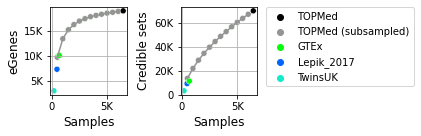

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 2))

palette = {
    'TOPMed': '#000000',
    'TOPMed (subsampled)': '#929591',
    'GTEx': '#01ff07',
    'Lepik_2017': '#0165fc',
    'TwinsUK': '#13eac9'
}

ax = axs[0]
sns.scatterplot(x='sample_size', y='egenes', data=main, ax=ax, hue='source', legend=False, palette=palette)
sns.lineplot(x='sample_size', y='egenes', data=main, ax=ax, hue='source', legend=False, palette=palette)
ax.set_xlabel('Samples', fontsize=12)
ax.set_ylabel('eGenes', fontsize=12)
ax.grid(True)
ax.yaxis.set_major_formatter(thousands)
ax.xaxis.set_major_formatter(thousands)


ax = axs[1]
sns.scatterplot(x='sample_size', y='cs', data=main, ax=ax, hue='source', palette=palette)
sns.lineplot(x='sample_size', y='cs', data=main, ax=ax, hue='source', legend=False, palette=palette)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='')
ax.set_xlabel('Samples', fontsize=12)
ax.set_ylabel('Credible sets', fontsize=12)
ax.grid(True)
ax.yaxis.set_major_formatter(thousands)
ax.xaxis.set_major_formatter(thousands)

fig.tight_layout()
fig.savefig(f'figures/{PREFIX}png', dpi=300, facecolor='white')